In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import math


def softmax(z):
    z -= np.max(z, axis=1, keepdims=True)
    ans = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
    return ans


def relu(z):
    z[z < 0] = 0
    return z


def relu_prime(z):
    z[z <= 0] = 0
    z[z > 0] = 1
    return z


def stochastic_J(w1, w2, y_hat, images, labels, alpha=0.):
    x = images
    y = labels
    m = x.shape[0]
    cost_mat = np.multiply(y, np.log(y_hat))
    cost = (-1. / m) * np.sum(np.sum(cost_mat, axis=1))
    # Regularize
    cost += (alpha / (2 * m)) * (np.linalg.norm(w1) + np.linalg.norm(w2))
    return cost


def J(w1, w2, b1, b2, images, labels, alpha=0.):
    x = images
    y = labels
    m = x.shape[0]
    h1, y_hat = feedforward(w1, w2, b1, b2, x, y)
    cost_mat = np.multiply(y, np.log(y_hat))
    cost = (-1. / m) * np.sum(np.sum(cost_mat, axis=1))
    # Regularize
    cost += (alpha / (2 * m)) * (np.linalg.norm(w1) + np.linalg.norm(w2))
    return cost


def feedforward(w1, w2, b1, b2, images, labels):
    x = images
    h1 = relu(x.dot(w1.T) + b1)
    y_hat = softmax(h1.dot(w2.T) + b2)
    return h1, y_hat


def grad_layer2(h1, y_hat, w1, w2, images, labels, alpha=0.):
    y = labels
    m = y.shape[0]
    dJ_dz2 = (y_hat - y)
    dJ_dw2 = dJ_dz2.T.dot(h1)
    #Regularize
    dJ_dw2 += (alpha/m) * w2
    dJ_b2 = np.sum(dJ_dz2, axis=0, keepdims=True)
    return dJ_dw2, dJ_b2


def grad_layer1(h1, y_hat, w1, w2, images, labels, alpha=0.):
    x = images
    y = labels
    m = y.shape[0]
    dJ_dh1 = (y_hat - y).dot(w2)
    g = dJ_dh1 * relu_prime(x.dot(w1.T))  # dJ/dz1
    dJ_dw1 = g.T.dot(x)
    # Regularize
    dJ_dw1 += (alpha / m) * w1
    dJ_db1 = np.sum(g, axis=0, keepdims=True)
    return dJ_dw1, dJ_db1


def gradientDescent(trainingimages, trainingLabels, h_nodes, epsilon, batch_size, epochs, alpha=0., searching=False):
    x = trainingimages
    y = trainingLabels
    sample_size, dimensions = x.shape
    classes = y.shape[1]
    cost_history = np.array([])

    w1_range = 1./math.sqrt(dimensions)
    w1 = np.random.uniform(-w1_range, w1_range, (h_nodes, dimensions))
    b1 = np.ones((1, h_nodes)) * 0.1
    w2_range = 1. / math.sqrt(h_nodes)
    w2 = np.random.uniform(-w2_range, w2_range, (classes, h_nodes))
    b2 = np.ones((1, classes)) * 0.1

    num_batches = sample_size / batch_size
    for e in xrange(epochs):
        batch_history = np.array([])

        x_y = np.append(x, y, axis=1)
        np.random.shuffle(x_y)
        x_s = x_y[:, :dimensions]
        y_s = x_y[:, dimensions:]
        for i in xrange(num_batches):
            start = i * batch_size
            end = start + batch_size
            x_batch = x_s[start:end]
            y_batch = y_s[start:end]
            # Do feedforward pass
            h1, y_hat = feedforward(w1, w2, b1, b2, x_batch, y_batch)
            # Find dJ/dw1 and dJ/d1
            gradw1, gradb1 = grad_layer1(h1, y_hat, w1, w2, x_batch, y_batch, alpha)
            # Find dJ/dw2 and dJ/dwb2
            gradw2, gradb2 = grad_layer2(h1, y_hat, w1, w2, x_batch, y_batch, alpha)
            w1 -= (epsilon * gradw1)
            b1 -= (epsilon * gradb1)
            w2 -= (epsilon * gradw2)
            b2 -= (epsilon * gradb2)
            # Cost of current mini-batch
            cost = stochastic_J(w1, w2, y_hat, x_batch, y_batch, alpha)
            # List of costs for all the mini-batches in current epoch
            batch_history = np.append(batch_history, cost)

        epoch_cost = np.mean(batch_history)
        # List of costs for epochs
        cost_history = np.append(cost_history, epoch_cost)
        # Accuracy of on validation data set after each epoch
        validation_acc = report_accuracy(w1, w2, b1, b2, validationImages, validationLabels)
        if e % 2 == 0:
            print("Epochs: %d Cost: %.5f Validation Acc: %.2f ||w1||: %.5f ||w2||: %.5f" % (
                e, epoch_cost, validation_acc, np.linalg.norm(w1), np.linalg.norm(w2)))

    if searching:
        # When searching best hyperparameters, return final cost (last element in cost_history) and
        # final validation accuracy. These will be heuristics when choosing the best hyperparameters
        return cost_history[-1], validation_acc

    plt.plot(np.linspace(1, epochs, epochs), cost_history, label="Training Cost")
    plt.legend('Cost')
    plt.ylabel('Training Cost')
    plt.xlabel('Epochs')
    plt.title("Cross-entropy cost values")
    plt.show()
    return w1, w2, b1, b2


def reportCosts(w1, w2, b1, b2, trainImg , trainLbl, valiImg, valiLbl, testImg, testLbl, alpha=0.):
    print "Training cost: {}".format(J(w1, w2, b1, b2, trainImg, trainLbl, alpha))
    print "Validation cost:  {}".format(J(w1, w2, b1, b2, valiImg, valiLbl, alpha))
    print "Testing cost:  {}".format(J(w1, w2, b1, b2, testImg, testLbl, alpha))


def report_accuracy(w1, w2, b1, b2, images, labels):
    h1, y_hat = feedforward(w1, w2, b1, b2, images, labels)
    acc = np.mean(np.argmax(y_hat, axis=1) == np.argmax(labels, axis=1))
    return acc * 100


def predict(images, labels, w1, w2, b1, b2):
    h1, y_hat = feedforward(w1, w2, b1, b2, images, labels)
    predicted = np.argmax(y_hat)
    real = np.argmax(labels)
    return predicted, real

def findBestHyperparameters():
    h_nodes = [20, 20, 20, 30, 30, 30, 40, 40, 20, 30]
    l_rate = [1e-4, 1e-4, 1e-5, 0.0005, 0.00002, 0.00001, 0.0006, 0.0006, 0.00007, 0.0007]
    b_size = [64, 32, 64, 128, 512, 256, 16, 64, 36, 16]
    alpha = [0.5, 0.8, 10, 1e2, 50, 0.2, 0.3, 0.7, 0.1, 0.001]
    epochs = 5
    min_cost = 100
    max_acc = 0
    best = 0
    for i in range(10):
        print ("Trying parameters - Hidden Nodes: %d Learning Rate: %.6f Batch Size: %d Alpha: %.3f Epochs: %d" % (
            h_nodes[i], l_rate[i], b_size[i], alpha[i], epochs))
        cost, acc = gradientDescent(trainingImages, trainingLabels, h_nodes[i], l_rate[i], b_size[i], epochs, alpha[i], searching=True)
        if cost < min_cost:
            min_cost = cost
            best = i
        if acc > max_acc:
            max_acc = acc
            best = i
        print ("Current best parameters - Hidden Nodes: %d Learning Rate: %.6f Batch Size: %d Alpha: %.3f Epochs: %d" % (
            h_nodes[best], l_rate[best], b_size[best], alpha[best], epochs))
    return h_nodes[i], l_rate[i], b_size[i], alpha[i], 10

if __name__ == "__main__":
    # Load data
    if 'trainingImages' not in globals():
        trainingImages = np.load("datasets/mnist_train_images.npy")
        trainingLabels = np.load("datasets/mnist_train_labels.npy")
        validationImages = np.load("datasets/mnist_validation_images.npy")
        validationLabels = np.load("datasets/mnist_validation_labels.npy")
        testingImages = np.load("datasets/mnist_test_images.npy")
        testingLabels = np.load("datasets/mnist_test_labels.npy")

    import time

    start = time.time()
    hidden_nodes, learning_rate, batch_size, ridge_term, epochs = findBestHyperparameters()
    print ("Best parameters - Hidden Nodes: %d Learning Rate: %.6f Batch Size: %d Alpha: %.3f Epochs: %d" %
           (hidden_nodes, learning_rate, batch_size, ridge_term, epochs))
    w_1, w_2, b_1, b_2 = gradientDescent(trainingImages, trainingLabels, hidden_nodes, learning_rate, batch_size, epochs, ridge_term)

    dt = int(time.time() - start)
    print("Execution time %d sec" % dt)

    reportCosts(w_1, w_2, b_1, b_2, trainingImages, trainingLabels, validationImages, validationLabels, testingImages, testingLabels)
    print "Accuracy on Validation set: ", report_accuracy(w_1, w_2, b_1, b_2, validationImages, validationLabels), "%"
    print "Accuracy on Testing set: ", report_accuracy(w_1, w_2, b_1, b_2, testingImages, testingLabels), "%"


Trying parameters - Hidden Nodes: 20 Learning Rate: 0.000100 Batch Size: 64 Alpha: 0.500 Epochs: 5
Epochs: 0 Cost: 1.66444 Validation Acc: 77.46 ||w1||: 3.35079 ||w2||: 2.90229
Epochs: 2 Cost: 0.56379 Validation Acc: 88.32 ||w1||: 4.45801 ||w2||: 4.14561
Epochs: 4 Cost: 0.43817 Validation Acc: 90.06 ||w1||: 4.92588 ||w2||: 4.65122
Current best parameters - Hidden Nodes: 20 Learning Rate: 0.000100 Batch Size: 64 Alpha: 0.500 Epochs: 5
Trying parameters - Hidden Nodes: 20 Learning Rate: 0.000100 Batch Size: 32 Alpha: 0.800 Epochs: 5
Epochs: 0 Cost: 1.68642 Validation Acc: 79.96 ||w1||: 3.37356 ||w2||: 2.88248
Epochs: 2 Cost: 0.63254 Validation Acc: 88.26 ||w1||: 4.44957 ||w2||: 4.10776
Epochs: 4 Cost: 0.51935 Validation Acc: 90.20 ||w1||: 4.89194 ||w2||: 4.59351
Current best parameters - Hidden Nodes: 20 Learning Rate: 0.000100 Batch Size: 32 Alpha: 0.800 Epochs: 5
Trying parameters - Hidden Nodes: 20 Learning Rate: 0.000010 Batch Size: 64 Alpha: 10.000 Epochs: 5
Epochs: 0 Cost: 2.26789 

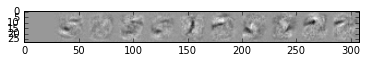

In [3]:
image = np.zeros((28,28))
for i in xrange(0,10):
    temp = w1[i].reshape(28,28)
    image = np.concatenate((image,temp), axis=1)
img_plt = plt.imshow(image, cmap='gray')
plt.show(img_plt)

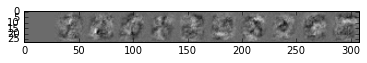

In [4]:
image = np.zeros((28,28))
for i in xrange(10,20):
    temp = w1[i].reshape(28,28)
    image = np.concatenate((image,temp), axis=1)
img_plt = plt.imshow(image, cmap='gray')
plt.show(img_plt)

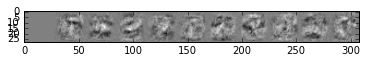

In [5]:
image = np.zeros((28,28))
for i in xrange(20,30):
    temp = w1[i].reshape(28,28)
    image = np.concatenate((image,temp), axis=1)
img_plt = plt.imshow(image, cmap='gray')
plt.show(img_plt)

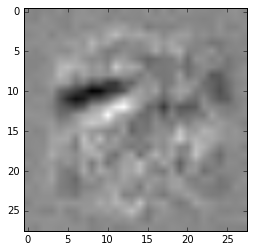

In [6]:
image = w1[9].reshape(28,28)
img_plt = plt.imshow(image, cmap='gray')
plt.show(img_plt)

In [7]:
def draw_image(x, y, title_str, drawTest = False):
    for c in range(1, 10):
        plt.subplot(3, 3,c)
        i = np.random.randint(x.shape[0]) 
        predicted, real = predict(x[i], y[i], w1, w2, b1, b2)
        im = testingImages[i].reshape((28,28)) 
        plt.axis("off")
        label = predicted
        plt.title("{} = {}".format(title_str, label))
        plt.imshow(im, cmap='gray')

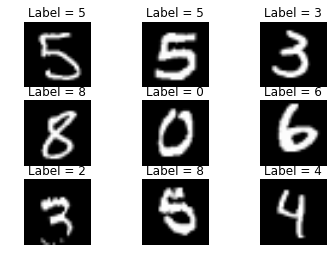

In [8]:
draw_image(testingImages, testingLabels, "Label")